In [1]:
import torch
import torch.nn as nn
import lightning as pl


import tensorboard as tb 
from train_bronze import LightningModel, get_dataset, get_config_for_dataset
from bronze_age.config import Config, DatasetEnum
from torch_geometric.loader import DataLoader

In [ ]:
tree_model = torch.load("lightning_logs/26/03/25 10:21 Infection mlp/CV_1/checkpoints/pruned_decision_tree_model.pt", weights_only=False)

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
input_tree : DecisionTreeClassifier = tree_model.input.tree

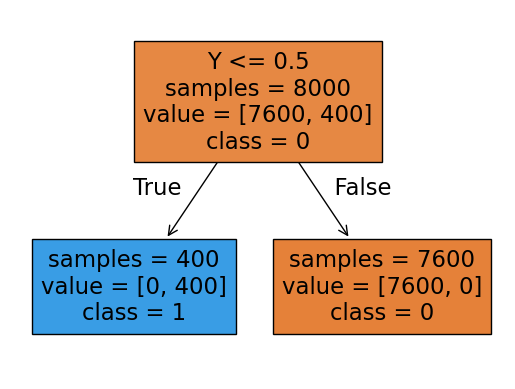

In [21]:
annotations = plot_tree(input_tree, feature_names=["x", "y", "z"], class_names=["0", "1"], filled=True, impurity=False)
for annotation in annotations:
    annotation.set_text(annotation.get_text().replace("x", "X").replace("y", "Y").replace("Z", "z"))


In [27]:
worse_model = """
=====================
Fold 1/10
Train accuracy: 0.8960000276565552
Validation accuracy: 0.8960000276565552
Test accuracy: 0.8960000276565552
=====================
=====================
Fold 2/10
Train accuracy: 0.6980000138282776
Validation accuracy: 0.6980000138282776
Test accuracy: 0.6980000138282776
=====================
=====================
Fold 3/10
Train accuracy: 0.8019999861717224
Validation accuracy: 0.8019999861717224
Test accuracy: 0.8019999861717224
=====================
=====================
Fold 4/10
Train accuracy: 0.6980000138282776
Validation accuracy: 0.6980000138282776
Test accuracy: 0.6980000138282776
=====================
=====================
Fold 5/10
Train accuracy: 0.703000009059906
Validation accuracy: 0.703000009059906
Test accuracy: 0.703000009059906
=====================
=====================
Fold 6/10
Train accuracy: 0.9010000228881836
Validation accuracy: 0.9010000228881836
Test accuracy: 0.9010000228881836
=====================
=====================
Fold 7/10
Train accuracy: 0.9950000047683716
Validation accuracy: 0.9950000047683716
Test accuracy: 0.9950000047683716
=====================
=====================
Fold 8/10
Train accuracy: 0.6980000138282776
Validation accuracy: 0.6980000138282776
Test accuracy: 0.6980000138282776
=====================
=====================
Fold 9/10
Train accuracy: 0.9950000047683716
Validation accuracy: 0.9950000047683716
Test accuracy: 0.9950000047683716
=====================
=====================
Fold 10/10
Train accuracy: 0.8960000276565552
Validation accuracy: 0.8960000276565552
Test accuracy: 0.8960000276565552
=====================
""" 

better_model = """
=====================
Fold 1/10
Train accuracy: 0.8019999861717224
Validation accuracy: 0.8019999861717224
Test accuracy: 0.8019999861717224
=====================
=====================
Fold 2/10
Train accuracy: 1.0
Validation accuracy: 1.0
Test accuracy: 1.0
=====================
=====================
Fold 3/10
Train accuracy: 1.0
Validation accuracy: 1.0
Test accuracy: 1.0
=====================
=====================
Fold 4/10
Train accuracy: 0.6980000138282776
Validation accuracy: 0.6980000138282776
Test accuracy: 0.6980000138282776
=====================
=====================
Fold 5/10
Train accuracy: 0.796999990940094
Validation accuracy: 0.796999990940094
Test accuracy: 0.796999990940094
=====================
=====================
Fold 6/10
Train accuracy: 0.9010000228881836
Validation accuracy: 0.9010000228881836
Test accuracy: 0.9010000228881836
=====================
=====================
Fold 7/10
Train accuracy: 0.8960000276565552
Validation accuracy: 0.8960000276565552
Test accuracy: 0.8960000276565552
=====================
=====================
Fold 8/10
Train accuracy: 0.6980000138282776
Validation accuracy: 0.6980000138282776
Test accuracy: 0.6980000138282776
=====================
=====================
Fold 9/10
Train accuracy: 0.9950000047683716
Validation accuracy: 0.9950000047683716
Test accuracy: 0.9950000047683716
=====================
=====================
Fold 10/10
Train accuracy: 0.9010000228881836
Validation accuracy: 0.9010000228881836
Test accuracy: 0.9010000228881836
=====================
"""

worse_model_test_acc = [0.8960000276565552, 0.6980000138282776, 0.8019999861717224, 0.6980000138282776, 0.703000009059906, 0.9010000228881836, 0.9950000047683716, 0.6980000138282776, 0.9950000047683716, 0.8960000276565552]
better_model_test_acc = [0.8019999861717224, 1.0, 1.0, 0.6980000138282776, 0.796999990940094, 0.9010000228881836, 0.8960000276565552, 0.6980000138282776, 0.9950000047683716, 0.9010000228881836]

In [28]:
len(worse_model_test_acc), len(better_model_test_acc)

(10, 10)

In [30]:
print("Worse model test accuracy:", sum(worse_model_test_acc)/len(worse_model_test_acc))
print("Better model test accuracy:", sum(better_model_test_acc)/len(better_model_test_acc))
# paired t-test
from scipy.stats import ttest_rel
t_statistic, p_value = ttest_rel(worse_model_test_acc, better_model_test_acc)
print("t-statistic:", t_statistic, "p-value:", p_value)

Worse model test accuracy: 0.8282000124454498
Better model test accuracy: 0.8688000082969666
t-statistic: -1.0242079484349147 p-value: 0.3324768732944945


In [14]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

event_acc = EventAccumulator('lightning_logs/26/03/25 18:55 Simple_Saturation mlp/CV_1')
event_acc.Reload()
print(event_acc.Tags())

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'train_entropy_loss', 'train_error_loss', 'train_loss', 'epoch', 'val_loss', 'val_acc', 'key', 'train_acc', 'test_loss', 'test_acc'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


In [18]:
print(event_acc.Scalars('test_acc')[-1].value)

0.9950000047683716


In [181]:
from pathlib import Path
def get_model_accuracies(path: Path):
    CV_subpaths = [path / f"CV_{i+1}" for i in range(10)]
    accuracies = []
    for CV_subpath in CV_subpaths:
        if not CV_subpath.exists():
            continue
        event_acc = EventAccumulator(str(CV_subpath))
        event_acc.Reload()
        if 'test_acc' in event_acc.Tags()['scalars']:
            accuracies.append(event_acc.Scalars('test_acc')[-1].value)
    return accuracies
    

/var/folders/4s/w1ynnlxd101c6csfgv45f7cr0000gn/T/ipykernel_40226/2031638124.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(data=df, x="Ablation", y="Test Accuracy", hue="Architecture", capsize=0.1, errwidth=1.5)


<Axes: xlabel='Ablation', ylabel='Test Accuracy'>

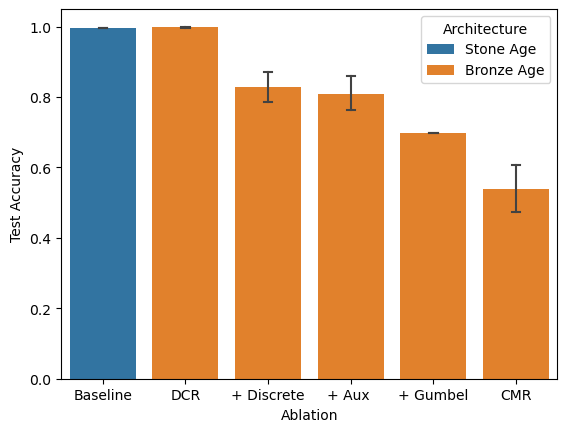

In [ ]:
import numpy as np
models = {"Stone Age": "lightning_logs/26/03/25 18:55 Simple_Saturation mlp", 
          "Bronze Age": "lightning_logs/26/03/25 19:00 Simple_Saturation deep-concept-reasoner",
          "Bronze Age (Discrete)": "lightning_logs/26/03/25 18:26 Simple_Saturation deep-concept-reasoner",
          "Bronze Age (Auxiliary)": "lightning_logs/27/03/25 00:06 Simple_Saturation deep-concept-reasoner",
          "Bronze Age (Gumbel)": "lightning_logs/26/03/25 18:44 Simple_Saturation deep-concept-reasoner",
          "Bronze Age (CMR)": "lightning_logs/26/03/25 18:28 Simple_Saturation memory-based-concept-reasoner",
          }

architecture = ["Stone Age", "Bronze Age", "Bronze Age", "Bronze Age", "Bronze Age", "Bronze Age"]
descriptions = ["Baseline", "DCR", "+ Discrete", "+ Aux ", "+ Gumbel", "CMR"]
accuracies = {}
for model_name, model_path in models.items():
    accuracies_ = get_model_accuracies(Path(model_path))
    accuracies[model_name] = accuracies_

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame(accuracies)
df = df.melt(var_name="Model", value_name="Test Accuracy")

df["Architecture"] = df["Model"].map({model_name: description for model_name, description in zip(models.keys(), architecture)})
df["Ablation"] = df["Model"].map({model_name: description for model_name, description in zip(models.keys(), descriptions)})

sns.barplot(data=df, x="Ablation", y="Test Accuracy", hue="Architecture", capsize=0.1, errwidth=1.5)
#plt.ylim(0, 1.0)


In [183]:
from bronze_age.models.bronze_age import BronzeAgeGNN, BronzeAgeLayer


dataset_enum = DatasetEnum.SIMPLE_SATURATION
config = get_config_for_dataset(dataset_enum)
dataset = get_dataset(config)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

dcr_path = next(iter((Path(models["Bronze Age"]) / "CV_1/checkpoints/").glob("epoch*.ckpt")))
dcr_model = LightningModel.load_from_checkpoint(str(dcr_path), model=BronzeAgeGNN(dataset.num_node_features, dataset.num_classes, config))
dcr_model = dcr_model.eval()



In [184]:
NUM_LAYERS = {
    DatasetEnum.INFECTION: 5,
    DatasetEnum.SATURATION: 1,
    DatasetEnum.SIMPLE_SATURATION: 1,
    DatasetEnum.BA_SHAPES: 5,
    DatasetEnum.TREE_CYCLE: 5,
    DatasetEnum.TREE_GRID: 5,
    DatasetEnum.BA_2MOTIFS: 4,
    DatasetEnum.MUTAG: 4,
    DatasetEnum.MUTAGENICITY: 3,
    DatasetEnum.BBBP: 3,
    DatasetEnum.PROTEINS: 3,
    DatasetEnum.IMDB_BINARY: 3,
    DatasetEnum.REDDIT_BINARY: 2,
    DatasetEnum.COLLAB: 3,
    DatasetEnum.SIMPLE_SATURATION: 1,
    DatasetEnum.DISTANCE: 1,
    DatasetEnum.PATH_FINDING: 1,
    DatasetEnum.PREFIX_SUM: 1,
    DatasetEnum.ROOT_VALUE: 1,
    DatasetEnum.GAME_OF_LIFE: 1,
    DatasetEnum.HEXAGONAL_GAME_OF_LIFE: 1,
}
NUM_STATES = {
    DatasetEnum.INFECTION: 6,
    DatasetEnum.SATURATION: 3,
    DatasetEnum.SIMPLE_SATURATION: 3,
    DatasetEnum.BA_SHAPES: 5,
    DatasetEnum.TREE_CYCLE: 5,
    DatasetEnum.TREE_GRID: 5,
    DatasetEnum.BA_2MOTIFS: 6,
    DatasetEnum.MUTAG: 6,
    DatasetEnum.MUTAGENICITY: 8,
    DatasetEnum.BBBP: 5,
    DatasetEnum.PROTEINS: 5,
    DatasetEnum.IMDB_BINARY: 5,
    DatasetEnum.REDDIT_BINARY: 5,
    DatasetEnum.COLLAB: 8,
    DatasetEnum.SIMPLE_SATURATION: 3,
    DatasetEnum.DISTANCE: 4,
    DatasetEnum.PATH_FINDING: 5,
    DatasetEnum.PREFIX_SUM: 6,
    DatasetEnum.ROOT_VALUE: 5,
    DatasetEnum.GAME_OF_LIFE: 2,
    DatasetEnum.HEXAGONAL_GAME_OF_LIFE: 2,
}
NUM_ITERATIONS = {
    DatasetEnum.DISTANCE: 12,
    DatasetEnum.PATH_FINDING: 12,
    DatasetEnum.PREFIX_SUM: 12,
    DatasetEnum.ROOT_VALUE: 3,
    DatasetEnum.GAME_OF_LIFE: 1,
    DatasetEnum.HEXAGONAL_GAME_OF_LIFE: 1,
}
BATCH_SIZES = {
    DatasetEnum.SATURATION : 1,
}

In [218]:
from bronze_age.config import BronzeConfig, AggregationMode, LayerTypeBronze as LayerType, LossMode
config = {
        "data_dir": "downloads",
        "temperature": 1.0,
        "dropout": 0.0,
        "use_batch_norm": True,
        "hidden_units": 16,
        "skip_connection": False,
        "bounding_parameter": 10,
        "learning_rate": 0.01,
        "max_epochs": 1500,
        "num_cv": 10,
        "dataset": dataset_enum,
        "num_layers": NUM_LAYERS[dataset_enum],
        "state_size": NUM_STATES[dataset_enum],
        "layer_type": LayerType.DEEP_CONCEPT_REASONER,
        "nonlinearity": None,
        "evaluation_nonlinearity": None,
        "concept_embedding_size": 16,
        "concept_temperature": 0.5,
        "entropy_loss_scaling": 0.0,
        "early_stopping": True,
        "loss_mode": LossMode.BINARY_CROSS_ENTROPY,
        "train_decision_tree": False,
        "aggregation_mode": AggregationMode.BRONZE_AGE,
        "num_recurrent_iterations": NUM_ITERATIONS.get(dataset_enum, 1),
        "teacher_max_epochs": 15,
        "train_concept_model": False,
        "student_layer_type": LayerType.MEMORY_BASED_CONCEPT_REASONER,
        "student_aggregation_mode": None,
        "concept_memory_disjunctions": 4,
    }
config = BronzeConfig(**config)
dcr_path = next(iter((Path(models["Bronze Age"]) / "CV_5/checkpoints/").glob("epoch*.ckpt")))
dcr_model = LightningModel.load_from_checkpoint(str(dcr_path), model=BronzeAgeGNN(dataset.num_node_features, dataset.num_classes, config))
dcr_model = dcr_model.eval()


dcr_layer_outputs = []
def capture_forward_hook(module, input, output):
    #print(type(module))
    if isinstance(module, BronzeAgeLayer):
        #print(output)
        dcr_layer_outputs.append(output[0].flatten())
knots = []
for name, module in dcr_model.model.named_modules():
    if isinstance(module, BronzeAgeLayer):
        knot = module.register_forward_hook(capture_forward_hook)
        knots.append(knot)
for data in loader:
    dcr_model.model(data.x, data.edge_index, data.batch)
for knot in knots:
    knot.remove()

dcr_layer_outputs = torch.cat(dcr_layer_outputs).detach().numpy()

In [210]:
from bronze_age.config import NonLinearity
config = {
        "data_dir": "downloads",
        "temperature": 1.0,
        "dropout": 0.0,
        "use_batch_norm": True,
        "hidden_units": 16,
        "skip_connection": False,
        "bounding_parameter": 10,
        "batch_size": BATCH_SIZES.get(dataset_enum, 128),
        "learning_rate": 0.01,
        "max_epochs": 1500,
        "num_cv": 10,
        "dataset": dataset_enum,
        "num_layers": NUM_LAYERS[dataset_enum],
        "state_size": NUM_STATES[dataset_enum],
        "layer_type": LayerType.DEEP_CONCEPT_REASONER,
        "nonlinearity": None,
        "evaluation_nonlinearity": NonLinearity.DIFFERENTIABLE_ARGMAX,
        "concept_embedding_size": 16,
        "concept_temperature": 0.5,
        "entropy_loss_scaling": 1.0,
        "early_stopping": True,
        "loss_mode": LossMode.BINARY_CROSS_ENTROPY,
        "train_decision_tree": False,
        "aggregation_mode": AggregationMode.BRONZE_AGE,
        "num_recurrent_iterations": NUM_ITERATIONS.get(dataset_enum, 1),
        "teacher_max_epochs": 15,
        "train_concept_model": False,
        "student_layer_type": LayerType.MEMORY_BASED_CONCEPT_REASONER,
        "student_aggregation_mode": None,
        "concept_memory_disjunctions": 4,
    }
config = BronzeConfig(**config)
aux_path = next(iter((Path(models["Bronze Age (Auxiliary)"]) / "CV_6/checkpoints/").glob("epoch*.ckpt")))
#aux_path = next(iter((Path("lightning_logs/26/03/25 23:17 Simple_Saturation deep-concept-reasoner/CV_1") / "checkpoints/").glob("epoch*.ckpt")))
aux_model = LightningModel.load_from_checkpoint(str(aux_path), model=BronzeAgeGNN(dataset.num_node_features, dataset.num_classes, config))
#aux_model = aux_model.eval()


aux_layer_outputs = []
def capture_forward_hook(module, input, output):
    #print(type(module))
    if isinstance(module, BronzeAgeLayer):
        #print(output)
        aux_layer_outputs.append(output[0].flatten())
knots = []
for name, module in aux_model.model.named_modules():
    if isinstance(module, BronzeAgeLayer):
        knot = module.register_forward_hook(capture_forward_hook)
        knots.append(knot)
for data in loader:
    aux_model.model(data.x, data.edge_index, data.batch)
for knot in knots:
    knot.remove()

aux_layer_outputs = torch.cat(aux_layer_outputs).detach().numpy()

<Axes: xlabel='Layer Output Values', ylabel='Count'>

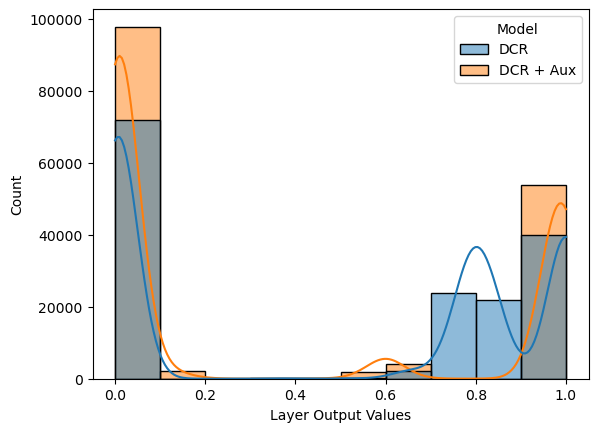

In [219]:
# histogram of layer outputs
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df = pd.DataFrame({"DCR": dcr_layer_outputs, "DCR + Aux": aux_layer_outputs})
df = df.melt(var_name="Model", value_name="Layer Output Values")
sns.histplot(df, x="Layer Output Values", hue="Model", bins=10, kde=True)
